In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [36]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import StadiaMapsTiles

In [2]:
from src.neural_networks.get_data import load_cv_data


2024-08-06 13:02:34.518293: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 13:02:34.520841: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 13:02:34.564903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 13:02:45.306130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


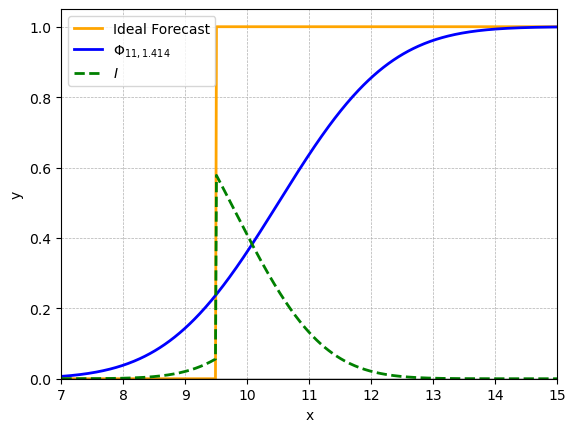

In [23]:
x = np.linspace(7, 15, 500)

observation = 9.5
mean_forecast = 10.5

# Indicator function
indicator = np.where(x > observation, 1, 0)

# Gaussian CDF with mean 9 and variance 2
mean = mean_forecast
variance = 2
gaussian_cdf = norm.cdf(x, loc=mean, scale=np.sqrt(variance))

# Plotting
plt.plot(x, indicator, label=r'Ideal Forecast', color='orange', linewidth=2)
plt.plot(x, gaussian_cdf, label=r'$\Phi_{11,1.414}$', color='blue', linewidth=2)
plt.plot(x, (indicator - gaussian_cdf) ** 2, label=r'$I$', color='green', linewidth=2, linestyle='--')

# Setting labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(7, 15)
plt.ylim(0,1.05)
# Adding legend
plt.legend()

# Display the plot
plt.show()


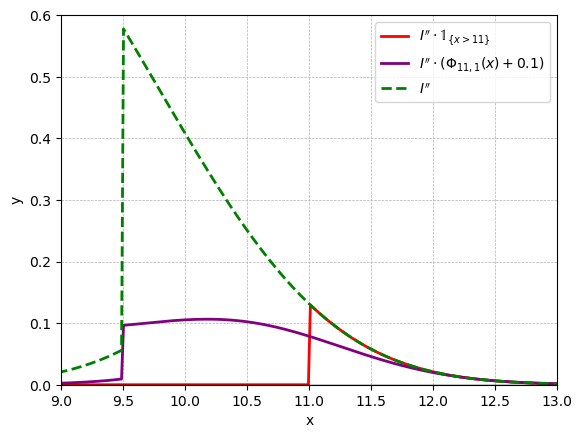

In [25]:
I = (gaussian_cdf - indicator) ** 2

I_ind = np.where(x > 11, 1, 0) * I
I_gauss = I * (norm.cdf(x, loc=11, scale=1) + 0.1)

plt.plot(x, I_ind, label=r'$I^{\prime\prime} \cdot \mathbb{1}_{\{x > 11\}}$', color='red', linewidth=2, linestyle='-')
plt.plot(x, I_gauss, label=r'$I^{\prime\prime} \cdot (\Phi_{11,1}(x) + 0.1)$', color='purple', linewidth=2)
plt.plot(x, I, label=r'$I^{\prime\prime}$' , color='green', linewidth=2, linestyle='--')

# Setting labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.xlim(9, 13)
plt.ylim(0,0.6)
# Adding legend
plt.legend()

# Display the plot
plt.show()

In [3]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [6]:
train_data1, test_data1, ignore = load_cv_data(1, features_names_dict)

train_data2, test_data2, ignore = load_cv_data(2, features_names_dict)

train_data3, test_data3, ignore = load_cv_data(3, features_names_dict)

In [7]:
test_data1 = test_data1.batch(test_data1.cardinality())

test_data2 = test_data2.batch(test_data2.cardinality())

test_data3 = test_data3.batch(test_data3.cardinality())

In [15]:
X, y = next(iter(test_data3))
print(y.shape)

(7780,)


In [16]:
print(np.mean(y))
print(np.quantile(y, 0.9))
print(np.quantile(y, 0.95))
print(np.quantile(y, 0.99))

5.365722
10.289999961853027
12.210000038146973
15.4399995803833


In [4]:
filename = '/net/pc200239/nobackup/users/hakvoort/station_info.pkl'
with open(filename, 'rb') as f:
    info = pickle.load(f)

In [27]:
lat_lons = []
codes = []
for key in info:
    lat = info[key].latitude
    lon = info[key].longitude
    lat_lons.append((lat, lon))
    codes.append(info[key].code)

In [28]:
print(codes)


['251', '235', '356', '350', '242', '343', '319', '313', '344', '258', '260', '310', '215', '275', '290', '286', '249', '330', '269', '370', '209', '270', '285', '377', '375', '315', '280', '340', '391', '279', '323', '273', '248', '225', '308', '324', '278', '283', '267', '348', '316', '229', '240', '312', '277', '331', '380']


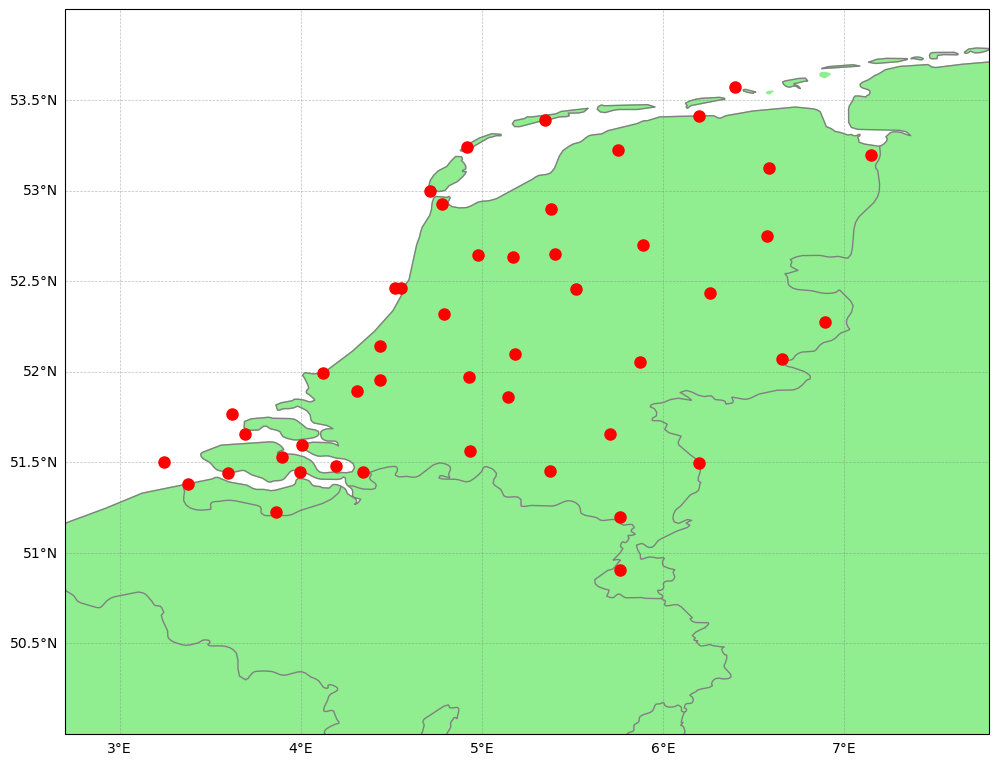

In [51]:
# Boundaries to zoom in
xmin, xmax = 2.7, 7.8
ymin, ymax = 50.0, 54.0

# Calculate aspect ratio of the region to match the figure's aspect ratio
aspect_ratio = (ymax - ymin) / (xmax - xmin)

# Initialize the map with a PlateCarree projection
plt.figure(figsize=(12, 12 * aspect_ratio))  # Adjust figure size based on aspect ratio
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
ax.add_feature(cfeature.LAND, color='lightgreen', zorder=-1)

# Add gridlines for better readability
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot the points and labels
for i, (lat, lon) in enumerate(lat_lons):
    ax.plot(lon, lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())
    # ax.text(lon + 0.03, lat + 0.03, codes[i], fontsize=8, fontweight='bold', 
    #         ha='left', va='center', color='darkblue', transform=ccrs.PlateCarree())

# Set the extent (zoom in on the specified region)
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add a title and show the plot
plt.show()

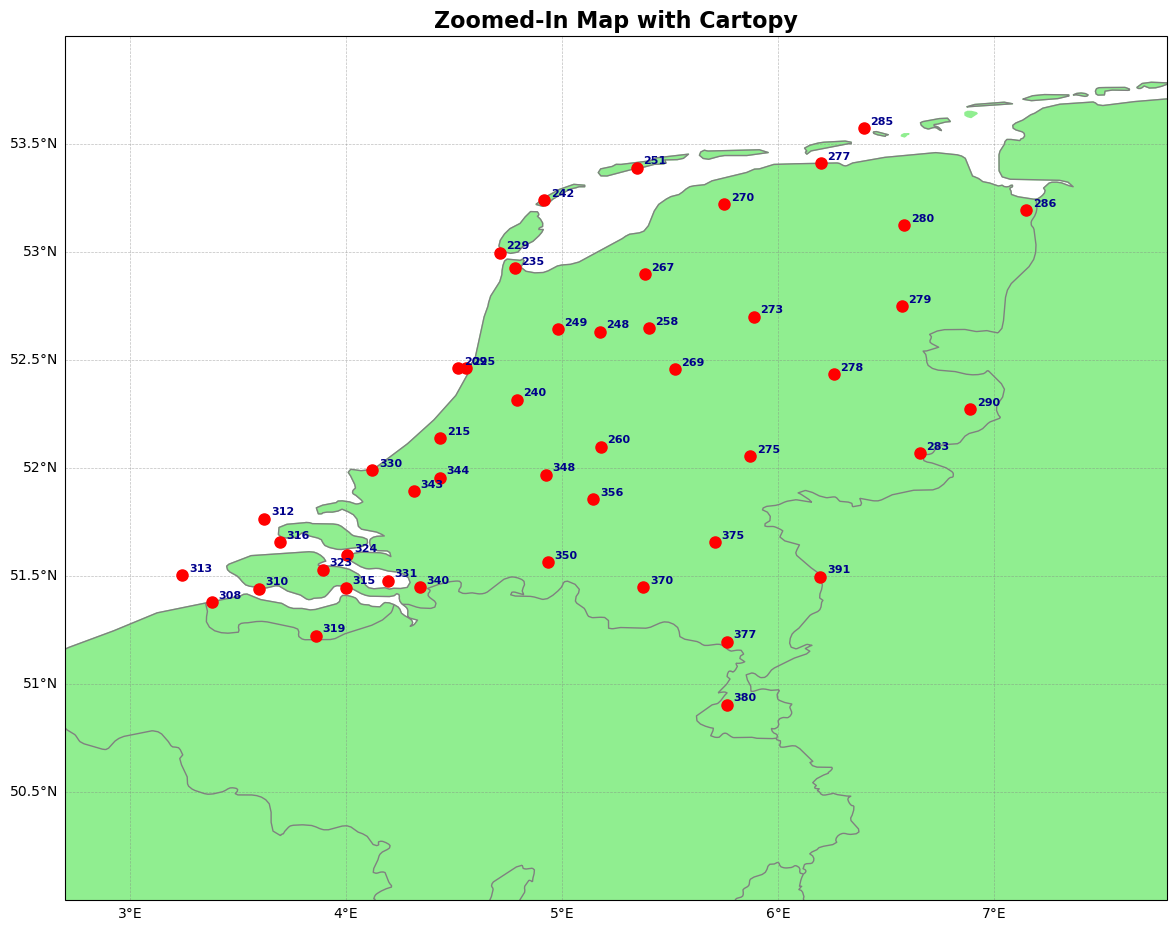

In [49]:
# Boundaries to zoom in
xmin, xmax = 2.7, 7.8
ymin, ymax = 50.0, 54.0

# Calculate aspect ratio of the region to match the figure's aspect ratio
aspect_ratio = (ymax - ymin) / (xmax - xmin)

# Initialize the map with a PlateCarree projection
plt.figure(figsize=(12, 12 * aspect_ratio))  # Adjust figure size based on aspect ratio
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='gray')
ax.add_feature(cfeature.LAND, color='lightgreen', zorder=-1)

# Add gridlines for better readability
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot the points and labels
for i, (lat, lon) in enumerate(lat_lons):
    ax.plot(lon, lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())
    ax.text(lon + 0.03, lat + 0.03, codes[i], fontsize=8, fontweight='bold', 
            ha='left', va='center', color='darkblue', transform=ccrs.PlateCarree())

# Set the extent (zoom in on the specified region)
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add a title and show the plot
plt.title('Zoomed-In Map with Cartopy', fontsize=16, fontweight='bold')
plt.tight_layout()  # Ensure there is no clipping of content
plt.show()